## **Predictive Modelling of unit sales for a prominent Ecuadorian grocery retailer : An Analysis for Corporation Favorita**
## BUSINESS UNDERSTANDING

The main goal of this analysis is to construct a precise model that predicts the unit sales of diverse items retailed at Favorita's stores. Utilizing historical sales data, supplementary information, and extractable features, the objective is to unveil patterns, factors, and trends that impact sales. This acquired knowledge will enable Favorita to refine inventory management, strategize promotions more efficiently, and improve overall sales performance.

             HYPOTHESIS

Null Hypothesis (H0): Promotional periods do not significantly increase store sales.


Alternative Hypothesis (H1): Promotional activities positively impact store sales, resulting in a noticeable increase.

### QUESTIONS

1. What are the top 10 stores in terms of sales?
 
2. What are the top 5 most frequently purchased product families?
 
3. Is there a noticeable correlation between promotions and sales?
 

 

## DATA UNDERSTANDING
## Importation

In [21]:
#data handling 
import pandas as pd 
import numpy as np
import pyodbc
from dotenv import dotenv_values
import itertools
import re
import warnings
warnings.filterwarnings("ignore")

#other utili
import joblib

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px 

#modelling

from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.tree import DecisionTreeRegressor

import xgboost as xgb
from xgboost import XGBRegressor


##  EDA

### Data Loading
#### **Training Set (Database)**

In [22]:
#PULLING VARIABLES from an environment
environment_variables = dotenv_values('.env')
 
database = environment_variables.get("database_name")
server = environment_variables.get("server_name")
username = environment_variables.get("user")
password = environment_variables.get("password")
 

connection_string = f"DRIVER={{SQL Server}};SERVER={server};DATABASE={database};UID={username};PWD={password}"
 

connection = pyodbc.connect(connection_string)

In [23]:
query = 'SELECT * FROM dbo.oil'
data = pd.read_sql(query, connection,parse_dates=['date'])
#convert to df
df_oil= pd.DataFrame(data)
df_oil.head(5)

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.139999
2,2013-01-03,92.970001
3,2013-01-04,93.120003
4,2013-01-07,93.199997


In [24]:
df_oil.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        1218 non-null   datetime64[ns]
 1   dcoilwtico  1175 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 19.2 KB


In [25]:
df_oil['dcoilwtico'].unique()

array([         nan,  93.13999939,  92.97000122,  93.12000275,
        93.19999695,  93.20999908,  93.08000183,  93.80999756,
        93.59999847,  94.26999664,  93.26000214,  94.27999878,
        95.48999786,  95.61000061,  96.08999634,  95.05999756,
        95.34999847,  95.15000153,  95.94999695,  97.62000275,
        97.98000336,  97.65000153,  97.45999908,  96.20999908,
        96.68000031,  96.44000244,  95.83999634,  95.70999908,
        97.01000214,  97.48000336,  97.02999878,  97.30000305,
        96.69000244,  94.91999817,  92.79000092,  92.73999786,
        92.62999725,  92.83999634,  92.02999878,  90.70999908,
        90.12999725,  90.87999725,  90.47000122,  91.52999878,
        92.01000214,  92.06999969,  92.44000244,  92.47000122,
        93.02999878,  93.48999786,  93.70999908,  92.45999908,
        93.41000366,  94.55000305,  95.98999786,  96.52999878,
        97.23999786,  97.09999847,  97.23000336,  95.01999664,
        92.76000214,  93.36000061,  94.18000031,  94.58

In [26]:
# round values to 2 decimal 
df_oil['dcoilwtico'] = df_oil['dcoilwtico'].round(2)

df_oil['dcoilwtico']

0         NaN
1       93.14
2       92.97
3       93.12
4       93.20
        ...  
1213    47.65
1214    46.40
1215    46.46
1216    45.96
1217    47.26
Name: dcoilwtico, Length: 1218, dtype: float64

In [27]:
# total missing values
print (f"missing values are {df_oil['dcoilwtico'].isna().sum()}")

missing values are 43


In [28]:
# back and forward fill tha null values
df_oil['dcoilwtico'] = df_oil['dcoilwtico'].ffill().bfill()

df_oil.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        1218 non-null   datetime64[ns]
 1   dcoilwtico  1218 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 19.2 KB


We observe the presence of approximately 43 missing values in the oil price data. Therefore, we plan to address this by employing a forward-fill method to fill the null values, followed by a back-fill method to handle any remaining missing rows.








In [29]:
df_oil['date'].unique()

<DatetimeArray>
['2013-01-01 00:00:00', '2013-01-02 00:00:00', '2013-01-03 00:00:00',
 '2013-01-04 00:00:00', '2013-01-07 00:00:00', '2013-01-08 00:00:00',
 '2013-01-09 00:00:00', '2013-01-10 00:00:00', '2013-01-11 00:00:00',
 '2013-01-14 00:00:00',
 ...
 '2017-08-18 00:00:00', '2017-08-21 00:00:00', '2017-08-22 00:00:00',
 '2017-08-23 00:00:00', '2017-08-24 00:00:00', '2017-08-25 00:00:00',
 '2017-08-28 00:00:00', '2017-08-29 00:00:00', '2017-08-30 00:00:00',
 '2017-08-31 00:00:00']
Length: 1218, dtype: datetime64[ns]


The oil dataset currently exhibits no null values and is expected to be comprehensive. However, we have identified instances of missing dates, such as the transition from January\4 \2013 to January\7\2013. A brief investigation reveals that these gaps correspond to weekends, indicating that the data specifically covers business days and excludes weekends. Given this observation, I infer that the oil prices during this period are static, and thus remain constant over the weekends. Consequently, to address "missing dates" (weekends), an additional forward-fill method is proposed.

In [73]:
df_oil["date"] = pd.to_datetime(df_oil["date"]).dt.date

In [31]:
# missing dates (Weekend)
missing_oil_dates = set(expected_days.date) - set(df_oil["date"].unique())
missing_oil_dates

{datetime.date(2013, 1, 5),
 datetime.date(2013, 1, 6),
 datetime.date(2013, 1, 12),
 datetime.date(2013, 1, 13),
 datetime.date(2013, 1, 19),
 datetime.date(2013, 1, 20),
 datetime.date(2013, 1, 26),
 datetime.date(2013, 1, 27),
 datetime.date(2013, 2, 2),
 datetime.date(2013, 2, 3),
 datetime.date(2013, 2, 9),
 datetime.date(2013, 2, 10),
 datetime.date(2013, 2, 16),
 datetime.date(2013, 2, 17),
 datetime.date(2013, 2, 23),
 datetime.date(2013, 2, 24),
 datetime.date(2013, 3, 2),
 datetime.date(2013, 3, 3),
 datetime.date(2013, 3, 9),
 datetime.date(2013, 3, 10),
 datetime.date(2013, 3, 16),
 datetime.date(2013, 3, 17),
 datetime.date(2013, 3, 23),
 datetime.date(2013, 3, 24),
 datetime.date(2013, 3, 30),
 datetime.date(2013, 3, 31),
 datetime.date(2013, 4, 6),
 datetime.date(2013, 4, 7),
 datetime.date(2013, 4, 13),
 datetime.date(2013, 4, 14),
 datetime.date(2013, 4, 20),
 datetime.date(2013, 4, 21),
 datetime.date(2013, 4, 27),
 datetime.date(2013, 4, 28),
 datetime.date(2013, 5, 

In [32]:
oil_dates_add = pd.DataFrame(missing_oil_dates, columns = ["date"])
oil_dates_add

,date
0,2013-11-09
1,2013-01-20
2,2015-02-28
3,2017-02-12
4,2014-04-12
...,...
477,2017-07-01
478,2014-02-02
479,2014-08-31
480,2014-10-12


In [33]:
# Add the  missing oil dates to the main dataframe
df_oil = pd.concat([df_oil, oil_dates_add], ignore_index=True)
df_oil["date"] = pd.to_datetime(df_oil["date"])
df_oil = df_oil.sort_values(by = ["date"], ignore_index = True)
df_oil.head()

,date,dcoilwtico
0,2013-01-01,93.14
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-05,NaN


In [34]:
# Fill nulls with forward fill and backfill
df_oil = df_oil.ffill().bfill()
df_oil.head()

,date,dcoilwtico
0,2013-01-01,93.14
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-05,93.12


In [35]:
df_oil.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1700 entries, 0 to 1699
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        1700 non-null   datetime64[ns]
 1   dcoilwtico  1700 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 26.7 KB


In [36]:
query = 'SELECT * FROM dbo.holidays_events'
data = pd.read_sql(query, connection,parse_dates=['date'])
#convert to df
df_holidays= pd.DataFrame(data)
df_holidays.head(5)

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [37]:
# general information
df_holidays.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         350 non-null    datetime64[ns]
 1   type         350 non-null    object        
 2   locale       350 non-null    object        
 3   locale_name  350 non-null    object        
 4   description  350 non-null    object        
 5   transferred  350 non-null    bool          
dtypes: bool(1), datetime64[ns](1), object(4)
memory usage: 14.1+ KB


In [38]:
# count of unique values 
df_holidays.nunique()

date           312
type             6
locale           3
locale_name     24
description    103
transferred      2
dtype: int64

In [39]:
df_holidays['type'].unique()

array(['Holiday', 'Transfer', 'Additional', 'Bridge', 'Work Day', 'Event'],
      dtype=object)

In [40]:
df_holidays["date"] = pd.to_datetime(df_holidays["date"]).dt.date
df_holidays.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   date         350 non-null    object
 1   type         350 non-null    object
 2   locale       350 non-null    object
 3   locale_name  350 non-null    object
 4   description  350 non-null    object
 5   transferred  350 non-null    bool  
dtypes: bool(1), object(5)
memory usage: 14.1+ KB


In [41]:
# missing dates 
missing_holi_dates = set(expected_days.date) - set(df_holidays["date"].unique())
missing_holi_dates

{datetime.date(2013, 2, 25),
 datetime.date(2013, 7, 15),
 datetime.date(2015, 5, 13),
 datetime.date(2016, 1, 7),
 datetime.date(2013, 1, 15),
 datetime.date(2013, 11, 9),
 datetime.date(2017, 2, 12),
 datetime.date(2014, 5, 6),
 datetime.date(2015, 5, 6),
 datetime.date(2013, 2, 5),
 datetime.date(2017, 3, 19),
 datetime.date(2014, 7, 30),
 datetime.date(2016, 7, 29),
 datetime.date(2016, 12, 9),
 datetime.date(2015, 5, 2),
 datetime.date(2016, 4, 13),
 datetime.date(2015, 2, 9),
 datetime.date(2016, 7, 30),
 datetime.date(2015, 10, 2),
 datetime.date(2015, 8, 14),
 datetime.date(2017, 1, 14),
 datetime.date(2014, 7, 7),
 datetime.date(2017, 7, 18),
 datetime.date(2013, 7, 12),
 datetime.date(2014, 3, 24),
 datetime.date(2016, 11, 23),
 datetime.date(2013, 4, 2),
 datetime.date(2017, 2, 2),
 datetime.date(2015, 6, 26),
 datetime.date(2014, 3, 6),
 datetime.date(2016, 1, 10),
 datetime.date(2014, 2, 14),
 datetime.date(2013, 12, 10),
 datetime.date(2014, 5, 13),
 datetime.date(2015, 1

In [42]:
# a dataframe for the missing dates in the df_holidays
holidays_add = pd.DataFrame(missing_holi_dates, columns = ["date"])
holidays_add

,date
0,2013-02-25
1,2013-07-15
2,2015-05-13
3,2016-01-07
4,2013-01-15
...,...
1427,2017-07-17
1428,2014-02-18
1429,2014-10-12
1430,2013-02-09


In [43]:
# Add  the  missing holiday dates to the main dataframe
df_holidays = pd.concat([df_holidays, holidays_add], ignore_index=True)
df_holidays["date"] = pd.to_datetime(df_holidays["date"]).dt.date
df_holidays = df_holidays.sort_values(by = ["date"], ignore_index = True)
df_holidays

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False
...,...,...,...,...,...,...
1777,2017-12-22,Holiday,Local,Salinas,Cantonizacion de Salinas,False
1778,2017-12-23,Additional,National,Ecuador,Navidad-2,False
1779,2017-12-24,Additional,National,Ecuador,Navidad-1,False
1780,2017-12-25,Holiday,National,Ecuador,Navidad,False


In [44]:
query = 'SELECT * FROM dbo.stores'
data = pd.read_sql(query, connection)
#convert to df
df_stores = pd.DataFrame(data)
df_stores.head(5)

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [45]:
df_stores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   store_nbr  54 non-null     int64 
 1   city       54 non-null     object
 2   state      54 non-null     object
 3   type       54 non-null     object
 4   cluster    54 non-null     int64 
dtypes: int64(2), object(3)
memory usage: 2.2+ KB


In [46]:
df_stores.nunique()

store_nbr    54
city         22
state        16
type          5
cluster      17
dtype: int64

#### **(csv)**

In [47]:
# the second dataset 
df_train = pd.read_csv(r"C:\Users\ndund\OneDrive\Documents\PYTHON\Time_Series_Forecasting\Datasets\train 1.csv",parse_dates=['date'])

df_train.head()



,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [48]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id           int64         
 1   date         datetime64[ns]
 2   store_nbr    int64         
 3   family       object        
 4   sales        float64       
 5   onpromotion  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 137.4+ MB


In [49]:
# round values to 2 decimal 
df_train['sales'] = df_train['sales'].round(2)

df_train['sales']

0             0.00
1             0.00
2             0.00
3             0.00
4             0.00
            ...   
3000883     438.13
3000884     154.55
3000885    2419.73
3000886     121.00
3000887      16.00
Name: sales, Length: 3000888, dtype: float64

In [50]:
df_train['date'].unique()

<DatetimeArray>
['2013-01-01 00:00:00', '2013-01-02 00:00:00', '2013-01-03 00:00:00',
 '2013-01-04 00:00:00', '2013-01-05 00:00:00', '2013-01-06 00:00:00',
 '2013-01-07 00:00:00', '2013-01-08 00:00:00', '2013-01-09 00:00:00',
 '2013-01-10 00:00:00',
 ...
 '2017-08-06 00:00:00', '2017-08-07 00:00:00', '2017-08-08 00:00:00',
 '2017-08-09 00:00:00', '2017-08-10 00:00:00', '2017-08-11 00:00:00',
 '2017-08-12 00:00:00', '2017-08-13 00:00:00', '2017-08-14 00:00:00',
 '2017-08-15 00:00:00']
Length: 1684, dtype: datetime64[ns]

In [51]:
df_train["sales_date"] = pd.to_datetime(df_train["date"]).dt.date
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 7 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id           int64         
 1   date         datetime64[ns]
 2   store_nbr    int64         
 3   family       object        
 4   sales        float64       
 5   onpromotion  int64         
 6   sales_date   object        
dtypes: datetime64[ns](1), float64(1), int64(3), object(2)
memory usage: 160.3+ MB


In [52]:
# Number of expected dates
expected_days = pd.date_range(start = df_train['sales_date'].min(), end = df_train['sales_date'].max())
expected_days

DatetimeIndex(['2013-01-01', '2013-01-02', '2013-01-03', '2013-01-04',
               '2013-01-05', '2013-01-06', '2013-01-07', '2013-01-08',
               '2013-01-09', '2013-01-10',
               ...
               '2017-08-06', '2017-08-07', '2017-08-08', '2017-08-09',
               '2017-08-10', '2017-08-11', '2017-08-12', '2017-08-13',
               '2017-08-14', '2017-08-15'],
              dtype='datetime64[ns]', length=1688, freq='D')

We observe a discrepancy of 4 days between the actual dates (1,684) and the expected dates (1,688) within the specified range. Consequently, it is necessary to identify and include these missing dates to ensure the dataset's comprehensive coverage of dates.

In [53]:
# missing dates
missing_dates = set(expected_days.date) - set(df_train['sales_date'].unique())
missing_dates

{datetime.date(2013, 12, 25),
 datetime.date(2014, 12, 25),
 datetime.date(2015, 12, 25),
 datetime.date(2016, 12, 25)}

In [54]:
# the unique store No.
Unq_store = df_train['store_nbr'].unique()
Unq_store

array([ 1, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,  2, 20, 21, 22, 23, 24,
       25, 26, 27, 28, 29,  3, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39,  4,
       40, 41, 42, 43, 44, 45, 46, 47, 48, 49,  5, 50, 51, 52, 53, 54,  6,
        7,  8,  9], dtype=int64)

In [55]:
# the unique store No.
Unq_family = df_train['family'].unique()
Unq_family

array(['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS',
       'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', 'DAIRY', 'DELI', 'EGGS',
       'FROZEN FOODS', 'GROCERY I', 'GROCERY II', 'HARDWARE',
       'HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES',
       'HOME CARE', 'LADIESWEAR', 'LAWN AND GARDEN', 'LINGERIE',
       'LIQUOR,WINE,BEER', 'MAGAZINES', 'MEATS', 'PERSONAL CARE',
       'PET SUPPLIES', 'PLAYERS AND ELECTRONICS', 'POULTRY',
       'PREPARED FOODS', 'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES',
       'SEAFOOD'], dtype=object)

In [56]:
#fill in the missing dates for each store We will do this with the product module from itertools
all_dates_stores = pd.DataFrame(list(itertools.product(missing_dates,Unq_family,Unq_store )), columns=['sales_date', 'family','store_nbr'])
all_dates_stores 

,sales_date,family,store_nbr
0,2015-12-25,AUTOMOTIVE,1
1,2015-12-25,AUTOMOTIVE,10
2,2015-12-25,AUTOMOTIVE,11
3,2015-12-25,AUTOMOTIVE,12
4,2015-12-25,AUTOMOTIVE,13
...,...,...,...
7123,2016-12-25,SEAFOOD,54
7124,2016-12-25,SEAFOOD,6
7125,2016-12-25,SEAFOOD,7
7126,2016-12-25,SEAFOOD,8


In [57]:
#merge 
df_train = pd.concat([df_train,all_dates_stores], ignore_index=True)
df_train

,id,date,store_nbr,family,sales,onpromotion,sales_date
0,0.0,2013-01-01,1,AUTOMOTIVE,0.0,0.0,2013-01-01
1,1.0,2013-01-01,1,BABY CARE,0.0,0.0,2013-01-01
2,2.0,2013-01-01,1,BEAUTY,0.0,0.0,2013-01-01
3,3.0,2013-01-01,1,BEVERAGES,0.0,0.0,2013-01-01
4,4.0,2013-01-01,1,BOOKS,0.0,0.0,2013-01-01
...,...,...,...,...,...,...,...
3008011,NaN,NaT,54,SEAFOOD,NaN,NaN,2016-12-25
3008012,NaN,NaT,6,SEAFOOD,NaN,NaN,2016-12-25
3008013,NaN,NaT,7,SEAFOOD,NaN,NaN,2016-12-25
3008014,NaN,NaT,8,SEAFOOD,NaN,NaN,2016-12-25


In [58]:
# Drop "id" and "date" columns
df_train.drop(columns = ["id", "date"], axis = 1, inplace = True)

# Fill missing rows in the sales and casting it to numeric
df_train["sales"].fillna(0, inplace = True)
df_train["sales"] = pd.to_numeric(df_train["sales"])

# Fill missing rows in the onpromotion column
df_train["onpromotion"].fillna(0, inplace = True)

df_train

,store_nbr,family,sales,onpromotion,sales_date
0,1,AUTOMOTIVE,0.0,0.0,2013-01-01
1,1,BABY CARE,0.0,0.0,2013-01-01
2,1,BEAUTY,0.0,0.0,2013-01-01
3,1,BEVERAGES,0.0,0.0,2013-01-01
4,1,BOOKS,0.0,0.0,2013-01-01
...,...,...,...,...,...
3008011,54,SEAFOOD,0.0,0.0,2016-12-25
3008012,6,SEAFOOD,0.0,0.0,2016-12-25
3008013,7,SEAFOOD,0.0,0.0,2016-12-25
3008014,8,SEAFOOD,0.0,0.0,2016-12-25


By excluding December 25 from each year, I presume this decision was intentional, likely reflecting the closure of all shops on this date.In other words, it is reasonable to fill the null values in the "sales" and "onpromotion" columns with 0 because there was no sale or promotion of items.

I am also dropping the "id" column as it will not be relevant and will be filling the missing dates in the original dates column with the sales data









In [59]:
# the third dataset 
df_trans = pd.read_csv(r"C:\Users\ndund\OneDrive\Documents\PYTHON\Time_Series_Forecasting\Datasets\transactions 1.csv",parse_dates=['date'])

df_trans.head()



,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


In [60]:
df_trans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83488 entries, 0 to 83487
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          83488 non-null  datetime64[ns]
 1   store_nbr     83488 non-null  int64         
 2   transactions  83488 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 1.9 MB


In [61]:
df_trans.nunique()

date            1682
store_nbr         54
transactions    4993
dtype: int64

In [62]:
df_trans["sales_date"] = pd.to_datetime(df_trans["date"]).dt.date
df_trans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83488 entries, 0 to 83487
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          83488 non-null  datetime64[ns]
 1   store_nbr     83488 non-null  int64         
 2   transactions  83488 non-null  int64         
 3   sales_date    83488 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 2.5+ MB


In [63]:
# missing dates
missing_tran_dates = set(expected_days.date) - set(df_trans['sales_date'].unique())
missing_tran_dates

{datetime.date(2013, 12, 25),
 datetime.date(2014, 12, 25),
 datetime.date(2015, 12, 25),
 datetime.date(2016, 1, 1),
 datetime.date(2016, 1, 3),
 datetime.date(2016, 12, 25)}

In [64]:
#fill in the missing dates for each store We will do this with the product module from itertools
tran_dates_stores = pd.DataFrame(list(itertools.product(missing_tran_dates,Unq_store )), columns=['sales_date', 'store_nbr'])
tran_dates_stores 

,sales_date,store_nbr
0,2016-01-03,1
1,2016-01-03,10
2,2016-01-03,11
3,2016-01-03,12
4,2016-01-03,13
...,...,...
319,2013-12-25,54
320,2013-12-25,6
321,2013-12-25,7
322,2013-12-25,8


In [65]:
#merge 
df_trans = pd.concat([df_trans,tran_dates_stores], ignore_index=True)
df_trans

,date,store_nbr,transactions,sales_date
0,2013-01-01,25,770.0,2013-01-01
1,2013-01-02,1,2111.0,2013-01-02
2,2013-01-02,2,2358.0,2013-01-02
3,2013-01-02,3,3487.0,2013-01-02
4,2013-01-02,4,1922.0,2013-01-02
...,...,...,...,...
83807,NaT,54,NaN,2013-12-25
83808,NaT,6,NaN,2013-12-25
83809,NaT,7,NaN,2013-12-25
83810,NaT,8,NaN,2013-12-25


In [66]:
# Drop "date" column
df_trans.drop(columns = ["date"], axis = 1, inplace = True)

# Fill missing rows in the transaction 
df_trans["transactions"].fillna(0, inplace = True)

df_trans

,store_nbr,transactions,sales_date
0,25,770.0,2013-01-01
1,1,2111.0,2013-01-02
2,2,2358.0,2013-01-02
3,3,3487.0,2013-01-02
4,4,1922.0,2013-01-02
...,...,...,...
83807,54,0.0,2013-12-25
83808,6,0.0,2013-12-25
83809,7,0.0,2013-12-25
83810,8,0.0,2013-12-25


As the df_train shares an equivalent count of unique stores with the df_trans, we can utilize the previously defined variable for Unq_store to address missing dates. Consequently, similar to the approach employed for the train data, we must identify and impute the missing dates in the transactions data.

### ANSWERING QUESTIONS

1. **What are the top 10 stores in terms of sales?**

In [67]:
# DataFrame containing merged data
top_stores_sales = df_train.groupby('store_nbr')['sales'].sum().sort_values(ascending=True).head(10).reset_index()

# Plot with Plotly
fig = px.bar(top_stores_sales, x='store_nbr', y='sales',
             title='Top 10 Stores by Total Sales',
             labels={'sales': 'Total Sales', 'store_nbr': 'Store Number'},
             color='sales',
             color_continuous_scale='viridis')

# Customize layout
fig.update_layout(xaxis_title='Store Number', yaxis_title='Total Sales')

fig.show()


2.  **What are the top 5 most frequently purchased product families?**

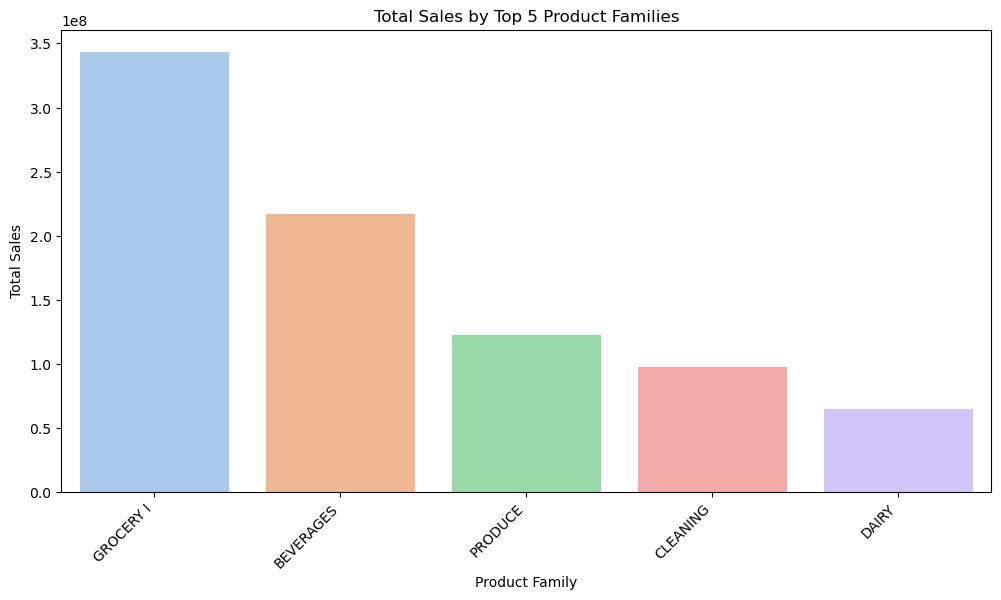

In [68]:
top_family_sales = df_train.groupby('family')['sales'].sum().nlargest(5).reset_index()

# color palette
colors = sns.color_palette('pastel')[:5]

# Plot bar chart with seaborn
plt.figure(figsize=(12, 6))
sns.barplot(x='family', y='sales', data=top_family_sales, palette=colors)
plt.title('Total Sales by Top 5 Product Families')
plt.xlabel('Product Family')
plt.ylabel('Total Sales')
plt.xticks(rotation=45, ha='right')
plt.show()


3. **Is there a noticeable correlation between promotions and sales?**

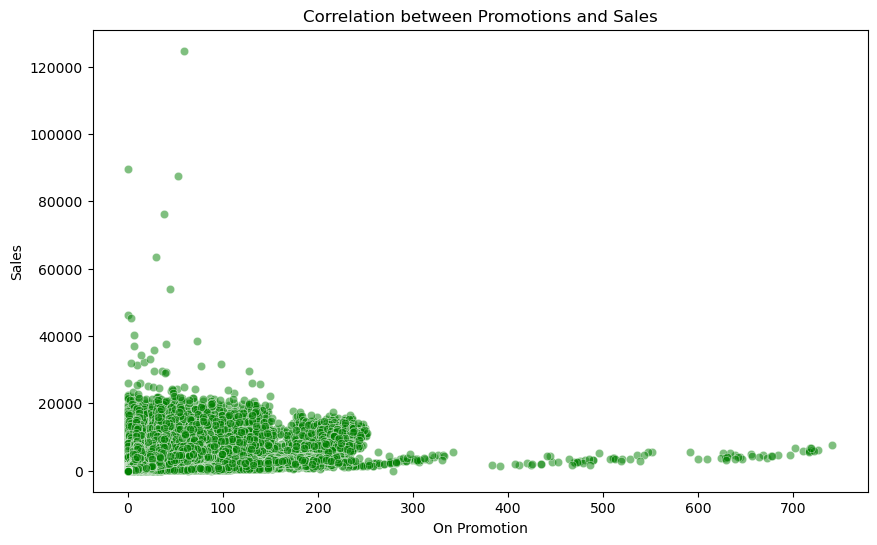

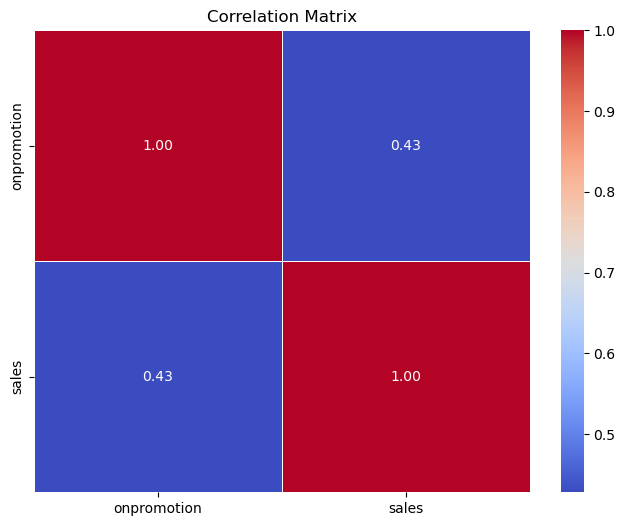

In [69]:
# Scatter plot for promotions and sales
plt.figure(figsize=(10, 6))
sns.scatterplot(x='onpromotion', y='sales', data=df_train, color='green', alpha=0.5)
plt.title('Correlation between Promotions and Sales')
plt.xlabel('On Promotion')
plt.ylabel('Sales')
plt.show()

# Correlation matrix
correlation_matrix = df_train[['onpromotion', 'sales']].corr()

#  correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix')
plt.show()

The correlation coefficient of 0.43 signifies a moderate positive correlation between sales and onpromotion. This implies that an increase in one variable tends to be associated with a corresponding increase in the other. The positive correlation suggests a tendency for higher sales during promotional periods (onpromotion=1), indicating a moderately heightened likelihood of increased sales. However, the moderate strength (0.43) indicates that, although there is a discernible relationship between promotions and sales, other influencing factors may contribute to sales variations.

## DATA PREPARATION

## Feature Engineering

In [70]:
df_stores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   store_nbr  54 non-null     int64 
 1   city       54 non-null     object
 2   state      54 non-null     object
 3   type       54 non-null     object
 4   cluster    54 non-null     int64 
dtypes: int64(2), object(3)
memory usage: 2.2+ KB


In [71]:
df_oil.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1700 entries, 0 to 1699
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        1700 non-null   datetime64[ns]
 1   dcoilwtico  1700 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 26.7 KB


In [74]:
# Merge train data with the oil and store dataframes
merge_data = pd.merge(df_train,df_stores) 
df_merged = pd.merge(merge_data, df_oil, left_on = "sales_date", right_on = "date") 
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3008016 entries, 0 to 3008015
Data columns (total 11 columns):
 #   Column       Dtype  
---  ------       -----  
 0   store_nbr    int64  
 1   family       object 
 2   sales        float64
 3   onpromotion  float64
 4   sales_date   object 
 5   city         object 
 6   state        object 
 7   type         object 
 8   cluster      int64  
 9   date         object 
 10  dcoilwtico   float64
dtypes: float64(3), int64(2), object(6)
memory usage: 252.4+ MB


In [75]:
df_merged["sales_date"] = pd.to_datetime(df_merged["sales_date"]).dt.date
df_holidays["sales_date"] = pd.to_datetime(df_holidays["date"]).dt.date
df_holidays.drop(columns = ["date"], inplace = True)

# Merging with the holidays data
df_merged = pd.merge(df_merged, df_holidays, on = "sales_date")
df_merged

,store_nbr,family,sales,onpromotion,sales_date,city,state,type_x,cluster,date,dcoilwtico,type_y,locale,locale_name,description,transferred
0,1,AUTOMOTIVE,0.0,0.0,2013-01-01,Quito,Pichincha,D,13,2013-01-01,93.14,Holiday,National,Ecuador,Primer dia del ano,False
1,1,BABY CARE,0.0,0.0,2013-01-01,Quito,Pichincha,D,13,2013-01-01,93.14,Holiday,National,Ecuador,Primer dia del ano,False
2,1,BEAUTY,0.0,0.0,2013-01-01,Quito,Pichincha,D,13,2013-01-01,93.14,Holiday,National,Ecuador,Primer dia del ano,False
3,1,BEVERAGES,0.0,0.0,2013-01-01,Quito,Pichincha,D,13,2013-01-01,93.14,Holiday,National,Ecuador,Primer dia del ano,False
4,1,BOOKS,0.0,0.0,2013-01-01,Quito,Pichincha,D,13,2013-01-01,93.14,Holiday,National,Ecuador,Primer dia del ano,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3061471,9,POULTRY,0.0,0.0,2016-12-25,Quito,Pichincha,B,6,2016-12-25,52.01,Holiday,National,Ecuador,Navidad,False
3061472,9,PREPARED FOODS,0.0,0.0,2016-12-25,Quito,Pichincha,B,6,2016-12-25,52.01,Holiday,National,Ecuador,Navidad,False
3061473,9,PRODUCE,0.0,0.0,2016-12-25,Quito,Pichincha,B,6,2016-12-25,52.01,Holiday,National,Ecuador,Navidad,False
3061474,9,SCHOOL AND OFFICE SUPPLIES,0.0,0.0,2016-12-25,Quito,Pichincha,B,6,2016-12-25,52.01,Holiday,National,Ecuador,Navidad,False


In [76]:
# check  nulls of the merged dataframe
df_merged.isnull().sum()

store_nbr            0
family               0
sales                0
onpromotion          0
sales_date           0
city                 0
state                0
type_x               0
cluster              0
date                 0
dcoilwtico           0
type_y         2551824
locale         2551824
locale_name    2551824
description    2551824
transferred    2551824
dtype: int64

In [77]:
# Fill  nulls in the holiday data
df_merged["type_y"] = df_merged["type_y"].fillna("Work Day")
df_merged["locale"] = df_merged["locale"].fillna("National")
df_merged["transferred"] = df_merged["transferred"].fillna(False)

df_merged.isnull().sum()

store_nbr            0
family               0
sales                0
onpromotion          0
sales_date           0
city                 0
state                0
type_x               0
cluster              0
date                 0
dcoilwtico           0
type_y               0
locale               0
locale_name    2551824
description    2551824
transferred          0
dtype: int64

In [78]:

# Drop columns 
df_merged.drop(columns = ["date", "locale_name","city","description"], inplace = True)


In [79]:
# Rename column names
df_merged.rename(columns = {"type_x":"store_type", "type_y":"holiday_type", "dcoilwtico":"oil_price"}, inplace = True)
df_merged

,store_nbr,family,sales,onpromotion,sales_date,state,store_type,cluster,oil_price,holiday_type,locale,transferred
0,1,AUTOMOTIVE,0.0,0.0,2013-01-01,Pichincha,D,13,93.14,Holiday,National,False
1,1,BABY CARE,0.0,0.0,2013-01-01,Pichincha,D,13,93.14,Holiday,National,False
2,1,BEAUTY,0.0,0.0,2013-01-01,Pichincha,D,13,93.14,Holiday,National,False
3,1,BEVERAGES,0.0,0.0,2013-01-01,Pichincha,D,13,93.14,Holiday,National,False
4,1,BOOKS,0.0,0.0,2013-01-01,Pichincha,D,13,93.14,Holiday,National,False
...,...,...,...,...,...,...,...,...,...,...,...,...
3061471,9,POULTRY,0.0,0.0,2016-12-25,Pichincha,B,6,52.01,Holiday,National,False
3061472,9,PREPARED FOODS,0.0,0.0,2016-12-25,Pichincha,B,6,52.01,Holiday,National,False
3061473,9,PRODUCE,0.0,0.0,2016-12-25,Pichincha,B,6,52.01,Holiday,National,False
3061474,9,SCHOOL AND OFFICE SUPPLIES,0.0,0.0,2016-12-25,Pichincha,B,6,52.01,Holiday,National,False


In [80]:
df_merged.nunique()

store_nbr           54
family              33
sales           157842
onpromotion        362
sales_date        1688
state               16
store_type           5
cluster             17
oil_price          994
holiday_type         6
locale               3
transferred          2
dtype: int64

In [81]:
#save
df_merged.to_csv("Lp3_df_merged.csv")

In [82]:
# function to get date features from df
def getDateFeatures(df, date):
    df["date"] = pd.to_datetime(df[date])
    df["day_of_week"] = df["date"].dt.dayofweek.astype(int)
    df["day_of_month"] = df["date"].dt.day.astype(int)
    df["day_of_year"] = df["date"].dt.dayofyear.astype(int)
    df["is_weekend"] = np.where(df["day_of_week"] > 4, 1, 0).astype(int)
    df["week_of_year"] = df["date"].dt.isocalendar().week.astype(int)
    df["month"] = df["date"].dt.month.astype(int)
    df["year"] = df["date"].dt.year.astype(int)
    df = df.drop(columns = "date")
    return df

In [83]:
# Get the date features from the Train Data
df_train = getDateFeatures(df_merged, "sales_date")
df_train = df_train.sort_values(by=["sales_date", "store_nbr"], ignore_index= True)
df_train

,store_nbr,family,sales,onpromotion,sales_date,state,store_type,cluster,oil_price,holiday_type,locale,transferred,day_of_week,day_of_month,day_of_year,is_weekend,week_of_year,month,year
0,1,AUTOMOTIVE,0.00,0.0,2013-01-01,Pichincha,D,13,93.14,Holiday,National,False,1,1,1,0,1,1,2013
1,1,BABY CARE,0.00,0.0,2013-01-01,Pichincha,D,13,93.14,Holiday,National,False,1,1,1,0,1,1,2013
2,1,BEAUTY,0.00,0.0,2013-01-01,Pichincha,D,13,93.14,Holiday,National,False,1,1,1,0,1,1,2013
3,1,BEVERAGES,0.00,0.0,2013-01-01,Pichincha,D,13,93.14,Holiday,National,False,1,1,1,0,1,1,2013
4,1,BOOKS,0.00,0.0,2013-01-01,Pichincha,D,13,93.14,Holiday,National,False,1,1,1,0,1,1,2013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3061471,54,POULTRY,59.62,0.0,2017-08-15,Manabi,C,3,47.57,Holiday,Local,False,1,15,227,0,33,8,2017
3061472,54,PREPARED FOODS,94.00,0.0,2017-08-15,Manabi,C,3,47.57,Holiday,Local,False,1,15,227,0,33,8,2017
3061473,54,PRODUCE,915.37,76.0,2017-08-15,Manabi,C,3,47.57,Holiday,Local,False,1,15,227,0,33,8,2017
3061474,54,SCHOOL AND OFFICE SUPPLIES,0.00,0.0,2017-08-15,Manabi,C,3,47.57,Holiday,Local,False,1,15,227,0,33,8,2017


In [84]:
# Encode categorical columns
catg = df_merged.select_dtypes(include=["object"]).columns.to_list()
catg.remove("sales_date")
catg

['family', 'state', 'store_type', 'holiday_type', 'locale']

In [ ]:
#  the encoder
catg_encoder = OneHotEncoder(drop = "first", sparse = False)

# Fit the encoder to the DataFrame
catg_encoder.fit(df_merged[catg])

encoded_catg = catg_encoder.transform(df_merged[catg])
encoded_catg = pd.DataFrame(encoded_catg, columns = catg_encoder.get_feature_names_out().tolist())
encoded_catg

,family_BABY CARE,family_BEAUTY,family_BEVERAGES,family_BOOKS,family_BREAD/BAKERY,family_CELEBRATION,family_CLEANING,family_DAIRY,family_DELI,family_EGGS,...,store_type_C,store_type_D,store_type_E,holiday_type_Bridge,holiday_type_Event,holiday_type_Holiday,holiday_type_Transfer,holiday_type_Work Day,locale_National,locale_Regional
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3061471,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3061472,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3061473,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3061474,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [ ]:
# Adding the encoded categoricals to the DataFrame and dropping the original columns
df_train.drop(columns= catg, inplace= True)
df_train = df_train.join(encoded_catg)

df_train.rename(columns= lambda x: re.sub("[^A-Za-z0-9_]+", "", x), inplace= True)
df_train

## Modelling

In [ ]:
# Split into train and eval
train = df_train.loc[df_train["year"].isin([2013, 2014, 2015, 2016])]
eval = df_train.loc[df_train["year"].isin([2017])]

# Drop columns
train.drop(columns = ["sales_date", "transferred"], inplace = True)
eval.drop(columns = ["sales_date", "transferred"], inplace = True)

In [ ]:
# Train data
X = train.drop(columns = "sales")
y = train["sales"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.25, random_state= 24)
print("X_train",X_train.shape,"y_train", y_train.shape)
print("X_test",X_test.shape, "y_test",y_test.shape)

In [ ]:
# columns to scale
col_scale = ["onpromotion"]

# Fit train data
mm_scaler = MinMaxScaler()
mm_scaler.fit(X_train[col_scale])

# Transform features
X_train[col_scale] = mm_scaler.transform(X_train[col_scale])
X_test[col_scale] = mm_scaler.transform(X_test[col_scale])

In [ ]:
#  models to use
models = {"Decision Tree": DecisionTreeRegressor(random_state = 24),
          #"Random Forest": RandomForestRegressor(random_state = 24),
          "XGBoost": XGBRegressor(random_state = 24)
         }

In [ ]:
#  function to fit models and score them
def fit_and_score(models, X_train = X_train, X_test = X_test, y_train = y_train, y_test = y_test):
    
    # An empty dictionary scores
    model_scores = {}
    model_mses = {}
    model_rmses = {}
    model_rmsles = {}
    
    # Loop 
    for name, model in models.items():
        
        # model start time
        training_start = pd.Timestamp.now()
        
        # fit
        model.fit(X_train, y_train)
        
        # get the feature importances
        model_feature_importances = pd.DataFrame(model.feature_importances_, columns=["importance_level"]).reset_index()
        model_feature_importances["Feature"] = list(X_train.columns)
        model_feature_importances.drop(columns=["index"], inplace= True)
        model_feature_importances.sort_values(by="importance_level", ascending= False, inplace = True)
        
        # predict
        y_pred = model.predict(X_test)
        
        #  model metrics
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        
        # check for negative predictions before RMSLE
        negative_preds = len(y_pred[y_pred < 0])
        if negative_preds <= 0.00:
            rmsle = np.sqrt(mean_squared_log_error(y_test, y_pred))
        else: rmsle = np.nan

        #  evaluation metrics together
        model_scores[name] = model.score(X_test, y_test)
        model_mses[name] = mse
        model_rmses[name] = rmse
        model_rmsles[name] = rmsle

        # model end time
        training_end = pd.datetime.now()
        
        
        train_duration = training_end - training_start
        print(name, "training duration:", train_duration)
        
    summary = pd.DataFrame([model_scores, model_mses, model_rmses, model_rmsles]).T
    summary.columns = ["R2", "MSE", "RMSE", "RMSLE"]
    return summary
        
        

In [ ]:
model_performances = fit_and_score(models, X_train, X_test, y_train, y_test)
model_performances

In [ ]:
# Fit model and making predictions
tree_model = DecisionTreeRegressor(random_state = 24)
tree_model = tree_model.fit(X_train, y_train)
y_pred = pd.DataFrame(tree_model.predict(X_test))

Looking at the summary table provided, it's evident that while the model performances are closely matched, the XGBoost model stands out with a null RMSLE score due to its tendency to make negative predictions. As a result, the Decision Tree model will be employed for the project at hand.

### Model Persistence

In [ ]:
#save model 
joblib.dump(tree_model,'DecisionTreeRegressor.joblib')
joblib.dump(catg_encoder,'OneHotEncoder.joblib')
joblib.dump(mm_scaler,'MinMaxScaler.joblib')

